In [81]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer

Download dataset
Create a jupyter notebook
Explore the data and create visualizations 1 & 2. Do visualization write-ups 1 & 2 in markup below them. 
Split the dataset randomly into train/test (80/20)
Preprocess the data properly:
one-hot encoding for categorical features
standardization for continuous features
count/tf-idf matrices (with or without SVD) and/or LDA for the text description
You must normalize the data using only information the training data (ex: don’t normalize by the mean of all data points). Write a few sentences in markup explaining how you preprocessed the data and why you did it this way.
You must use text data as input to your model
Chose a variety of ML algorithms (at least 3) to test
Example libraries: scikit-learn, lightGBM, xgboost, TensorFlow
Example algorithms: Linear regression, ridge regression, GBRT, MLP, Random Forest, SVR
Write a couple of sentences in markup justifying your choices
Find the optimal hyperparameters for each of your 3 chosen models using 10-fold cross-validation on your train set (same folds for each of the 3 models)
Use a grid search, random search, etc - whatever is most appropriate for the hyperparameters
You must use an appropriate and meaningful evaluation metric for this regression task
Write a couple sentences in markup describing how you found the optimal hyperparameters and why that was the appropriate method to find them
Create visualization 3. Do visualization write-up in markup below it. 
Using the optimal hyperparameters from the best performing model of the 3, predict the values for your test set and report performance (must use an appropriate and meaningful evaluation metric for this task)
Create visualization 4. Do visualization write-up in markup below it. 


# EDA

In [82]:
whole_data =pd.read_csv('winemag-data-130k-v2.csv')
whole_data.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [83]:
whole_data.describe()

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


## Analysis of duplicates present in data

In [84]:
print("Total number of examples: ", whole_data.shape[0])
print("Number of examples with the same title and description: ", whole_data[whole_data.duplicated(['description','title'])].shape[0])

whole_data = whole_data.drop_duplicates(['description','title'])
whole_data= whole_data.reset_index(drop=True)
print('Number of datapoints after removing duplicates:',len(whole_data))

Total number of examples:  129971
Number of examples with the same title and description:  9983
Number of datapoints after removing duplicates: 119988


- We remove data points where the description and title are duplicates

In [85]:
whole_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119988 entries, 0 to 119987
Data columns (total 14 columns):
Unnamed: 0               119988 non-null int64
country                  119929 non-null object
description              119988 non-null object
designation              85443 non-null object
points                   119988 non-null int64
price                    111593 non-null float64
province                 119929 non-null object
region_1                 100428 non-null object
region_2                 46769 non-null object
taster_name              95071 non-null object
taster_twitter_handle    90542 non-null object
title                    119988 non-null object
variety                  119987 non-null object
winery                   119988 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 12.8+ MB


In [86]:
#Summary of Missing values
total = whole_data.isnull().sum().sort_values(ascending = False)
percent = (whole_data.isnull().sum()/whole_data.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
region_2,73219,61.021936
designation,34545,28.790379
taster_twitter_handle,29446,24.540787
taster_name,24917,20.766243
region_1,19560,16.301630
price,8395,6.996533
province,59,0.049172
country,59,0.049172
variety,1,0.000833
winery,0,0.000000


- We have columns where more than 25% of their values are missing
- 'region_2', 'designation', 'taster_twitter_handle','taster_name' are pre-dominantly empty so it is a good idea to not consider it
- We drop data points that have no price value or region_1
- We do not consider 'Unnamed:0' feature

In [87]:
whole_data = whole_data.drop(columns=['Unnamed: 0', 'taster_twitter_handle','region_2','designation','taster_name'])
whole_data = whole_data.reset_index(drop=True)
whole_data = whole_data.dropna(subset=['price','region_1'])

whole_data = whole_data.reset_index(drop=True)

## Train and test split

In [88]:
y = whole_data['points'] 
X = whole_data.drop(columns = ['points'])
#split the data in train and test chunks
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


## Exploring the target variable

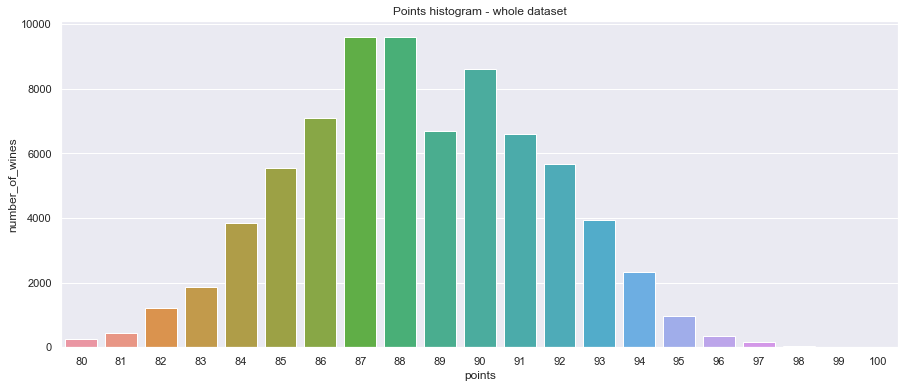

In [89]:
temp = y_train.value_counts()
df = pd.DataFrame({'points': temp.index,
                   'number_of_wines': temp.values
                  })


plt.figure(figsize = (15,6))
plt.title('Points histogram - whole dataset')
sns.barplot(x = 'points', y='number_of_wines', data=df)
locs, labels = plt.xticks()
plt.show()

Critique/Explanation:
I select a histogram to show the distribution of the wine points. Here we have two variables points and the number of wines under that point. A histogram depicts these variables using bars as marks and length of these bars as channel. I use a color pallete encoding to display different points. 

## Exploring the distribution of wine by province

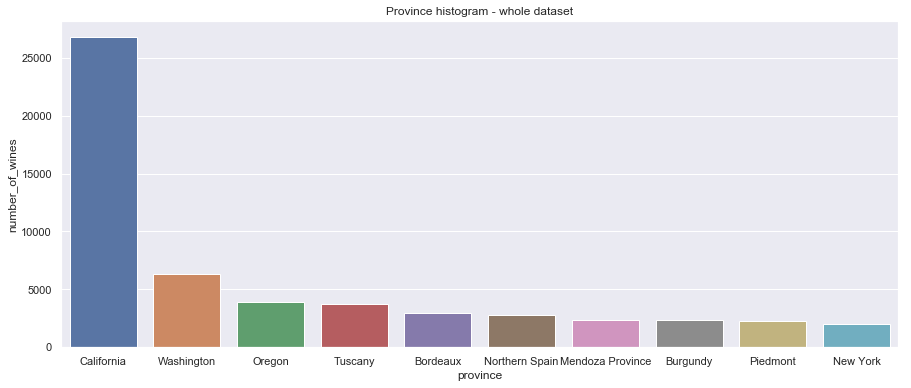

In [90]:
# Selecting top 10 provinces
temp = X_train["province"].value_counts().head(10)
df = pd.DataFrame({'province': temp.index,
                   'number_of_wines': temp.values
                  })

plt.figure(figsize = (15,6))
plt.title('Province histogram - whole dataset')
sns.barplot(x = 'province', y='number_of_wines', data=df)
locs, labels = plt.xticks()
plt.show()

Critique/Explanation:
I select a barplot to show the distribution of wine across top ten provinces. Here we have two variables provinces and the number of wines. A barplot depicts these variables using bars as marks and length of these bars as channel. I use a color pallete encoding to help distinguish different provinces. 

## Exploring price vs points

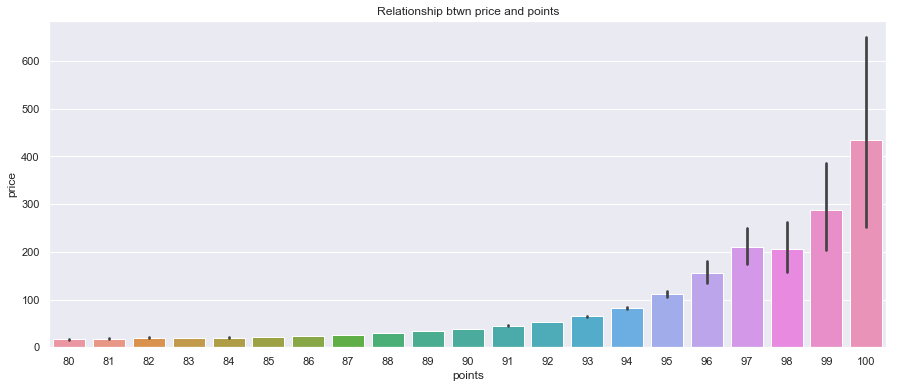

In [91]:
sns.set()

df = pd.DataFrame({'price': X_train['price'],
                   'points': y_train
                  })
plt.figure(figsize = (15,6))
plt.title('Relationship btwn price and points')
sns.barplot(x="points", y="price", data=df)
locs, labels = plt.xticks()
plt.show()

Critique/Explanation:
I select a barplot to visualize the relationship between the points and the price of wine. As expected we observe that the price of wine increases with the increase in points. Here, there are two variables the points and price. Both are quantitative in nature and so we select a barplot to show their relationship. The bars act as marks and the length of these bars is a channel. I also use different colors to show different discrete classes of points.

# Feature Engineering

## Dividing the train matrix in categorical, continuous and textual features

In [92]:
#normalizing the scale for prices feature
X_train['price'] = preprocessing.scale(X_train['price'])
X_test['price'] = preprocessing.scale(X_test['price'])

C:\Users\HP\Anaconda3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\HP\Anaconda3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [93]:
X_train.columns

Index(['country', 'description', 'price', 'province', 'region_1', 'title',
       'variety', 'winery'],
      dtype='object')

In [95]:
text_features = X_train[['description','title']]
nontext_features = X_train[['country', 'province', 'region_1', 'variety', 'winery', 'price']]

text_features_test = X_test[['description','title']]
nontext_features_test = X_test[['country', 'province', 'region_1', 'variety', 'winery', 'price']]

## Converting the categorical features to numerical representation

- We create a mapping using a single label encoder throughout the dataset

In [101]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder 
d = defaultdict(LabelEncoder)

# Encoding the variable
fit = nontext_features.apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
df_categorical = nontext_features.apply(lambda x: d[x.name].transform(x))
print(d)
#df_categorical_test = nontext_features_test.apply(lambda x: d.get(x.name,'winery').transform(x))

C:\Users\HP\Anaconda3.6\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3.6\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3.6\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3.6\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

defaultdict(<class 'sklearn.preprocessing.label.LabelEncoder'>, {'price': LabelEncoder(), 'variety': LabelEncoder(), 'province': LabelEncoder(), 'winery': LabelEncoder(), 'country': LabelEncoder(), 'region_1': LabelEncoder()})


In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer


corpus = text_features['description']+text_features['title']
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 500)
vectorizer.fit(corpus)

sdf_text = pd.SparseDataFrame(vectorizer.transform(corpus),
                         columns=vectorizer.get_feature_names(), 
                         default_fill_value=0)

- We create a tf-df feature representation that removes stop words and has 500 features

In [103]:
sdf_text.shape

(74864, 500)

In [104]:
df_categorical.shape

(74864, 6)

## Combining the if-df representation with the label encoded matrix

In [105]:
for c in sdf_text.columns:
    for d in df_categorical.columns:
        if c==d:
            df_categorical = df_categorical.rename(index=str, columns={d:d+'_'})
for col in df_categorical.columns:
    sdf_text[col] = df_categorical[col]

In [106]:
sdf_text.shape

(74864, 506)

## Train and validation split

In [107]:
X_train, X_val, y_train, y_val = train_test_split(sdf_text, y_train, test_size=0.10, random_state=1)

In [108]:
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

In [61]:
# saving the data to pickle
X_train.to_pickle("./trainX.pkl")
y_train.to_pickle("./trainY.pkl")
X_val.to_pickle("./valX.pkl")
y_val.to_pickle("./valY.pkl")

In [62]:
#loading pickles
X_train = pd.read_pickle("./trainX.pkl")
y_train = pd.read_pickle("./trainY.pkl")

# Model 1: Linear Regression

In [111]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_val, y_val)
y_pred_1 = reg.predict(X_val)

- We use Vanilla regression model which requires no hyperparamter tuning as baseline

# Model 2: Ridge Regression

In [110]:
from sklearn.linear_model import Ridge
import numpy as np

clf = Ridge(alpha=10)
clf.fit(X_train, y_train) 
clf.score(X_val,y_val)
y_pred_2 = clf.predict(X_val)

- Ridge regression introduces a regularization factor that penalizes the model, resulting in increased accuracy compared to simple linear regression method
- we run grid search to find best value of alpha (regularizing parameter)

In [74]:
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': [1,10,50,100]}
clf = GridSearchCV(Ridge(), parameters, cv=10)
clf.fit(X_train, y_train) 
clf.score(X_val,y_val)

0.5955217282785201

- We search for the best value of alpha for which the R^2 score is maximum
- the score function returns the value of R^2 score
- The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

# Model 3: Random forest regressor

In [112]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth = 10, random_state=0,n_estimators=100)
regr.fit(X_train, y_train)
regr.score(X_val,y_val)
y_pred_3 = regr.predict(X_val)

- We select this model because, a random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

In [113]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': [5,7,10,12,14]}
clf = GridSearchCV(RandomForestRegressor(max_depth = 4, random_state=0), parameters, cv=10)
clf.fit(X_train, y_train) 
clf.score(X_val,y_val)

- To find the best value of 'n_estimators' we run the algorithm for different values and select the value with highest score
- the score function returns the value of R^2 score
- The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse)
- Best value is when n_estimators = 10

# Visualizing model performances

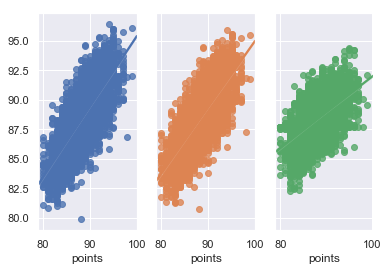

In [115]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
sns.regplot(x=y_val, y = y_pred_1, ax=ax1)
sns.regplot(x=y_val, y = y_pred_2, ax=ax2)
sns.regplot(x=y_val, y = y_pred_3, ax=ax3)

Explanation/critique:
The main task for this visualization is to understand and compare the models with each other. We have two continous variables here the predicted value with the actual value. The scatterplot shows the relation between these variables along with the regression line estimate.
The points act as marks and the channel is position. We use different color encoding for each model.
<p>
    We interpret that the performance for the ridge regressor is the best as it has a less spread out scatter followed by the simple linear regression and the random forest regressor performs the worst.

# Predicting test set using best model

In [118]:
from sklearn.ensemble import RandomForestRegressor

y_test_predicted = clf.predict(X_test)

# Visualize top features learned by best model

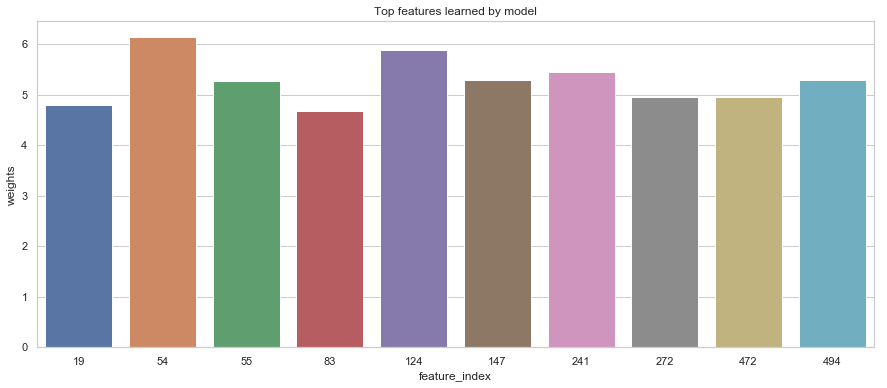

In [125]:
top_feature_index = clf.coef_.argsort()[-10:][::-1]
top_feature_values = [clf.coef_[val] for val in top_feature_index]
df = pd.DataFrame({'weights': top_feature_values,
                   'feature_index': top_feature_index
                  })

sns.set(style="whitegrid")

plt.figure(figsize = (15,6))
plt.title('Top features learned by model')

ax = sns.barplot(x="feature_index", y="weights", data=df)
locs, labels = plt.xticks()
plt.show()


Explantion:
The task is to visualize the magnitude of the top features that our model learns.
We have one quantitative variable and one categorical variable. To visualize this efficiently we use a bar plot. The bars are marks and their length is channel. We color coded different fatures to distinguish amongst them.